In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
from misc import rcsetup
rcsetup()

In [2]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))

In [3]:
class Vocabulary:

    def __init__(self, word_counts):
        self.words = np.array([word for word, c in word_counts])
        self.counts = np.array([c for word, c in word_counts])
        self.word2token = {word:tok for tok, word in enumerate(self.words)}
        self.size = len(self.words)

    def get_count(self, word):
        if word not in self.word2token:
            return 0
        return self.counts[self.word2token.get(word)]

    def to_words(self, tokens):
        return " ".join([self.words[tok] for tok in tokens])

# Prepare word embeddings

In [4]:
VOCAB_SZ = 25_000
data_dir = os.path.join(os.getenv("DATASETPATH"), "enwiki", "min200")

data_fm = FileManager(data_dir)
word_counts = data_fm.load("word_counts.pickle")
vocab = Vocabulary(word_counts)

In [5]:
print(f"Computing M*... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
unigram = vocab.counts[:VOCAB_SZ] / vocab.counts[:VOCAB_SZ].sum()
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
print("done.")

Computing M*... done.


In [6]:
def get_asym_embeds(M):
    M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
    eigvals, eigvecs = torch.linalg.eigh(M_gpu)
    eigvals = eigvals.cpu().numpy().astype(np.float64)
    eigvecs = eigvecs.cpu().numpy().astype(np.float64)
    del M_gpu
    torch.cuda.empty_cache()
    
    signs = np.sign(eigvals)
    sort_idx = np.argsort(np.abs(eigvals))[::-1]
    eigvals = np.abs(eigvals)[sort_idx]
    signs = signs[sort_idx]
    eigvecs = eigvecs[:, sort_idx]
    embeds = eigvecs * np.sqrt(eigvals[None, :])
    return embeds, signs

embeds, signs = get_asym_embeds(Mstar)

# Months

In [7]:
month_names = ["january", "february", "march", "april", "may", "june",
               "july", "august", "september", "october", "november", "december"]
month_abbr = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_nums = np.arange(12)

month_idxs = []
for month in month_names:
  if str(month) not in vocab.word2token:
    print(month)
    continue
  month_idxs.append(vocab.word2token[month])
month_idxs = np.array(month_idxs)

month_colors = np.array(get_color(1 - np.arange(12)/12.0, cmap='hsv'))
month_colors = np.roll(month_colors, 7, axis=0)

seasonal_words = ['winter', 'ski', 'easter', 'flower', 'spring', #'rain',
                  'summer', 'hurricane', 'autumn', 'halloween', 'christmas']

all_seasonal_idxs = []
for word in month_names + seasonal_words:
    if str(word) not in vocab.word2token:
        print(word)
        continue
    all_seasonal_idxs.append(vocab.word2token[word])
all_seasonal_idxs = np.array(all_seasonal_idxs)

In [8]:
# zeroing only the month-month co-occurrences
Mstar_zero = Mstar.copy()
Mstar_zero[np.ix_(month_idxs, month_idxs)] = 0.0
W_zero, _ = get_asym_embeds(Mstar_zero)

In [9]:
dmax = 1000
W_zero_months = W_zero[month_idxs, :dmax]
W_months_nomay = np.delete(W_zero_months, 4, axis=0)
mu = W_months_nomay.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_months_nomay - mu), full_matrices=False)

W_zero_months = (W_zero_months - mu) @ Vt.T
gram_zero = W_zero_months @ W_zero_months.T

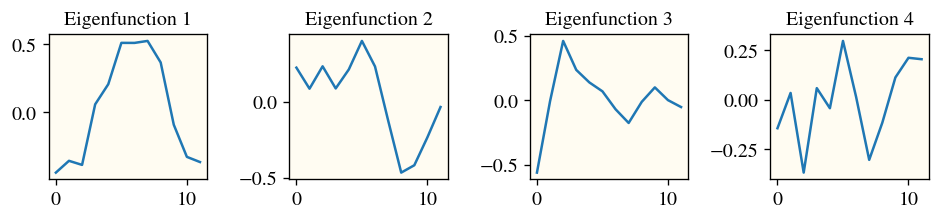

In [10]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(8,2))
for i, ax in enumerate(axes.flat):
    eigfn_idx = i
    eigfn = W_zero_months[:, eigfn_idx]
    ax.plot(month_nums, eigfn)
    ax.set_title(f'Eigenfunction {eigfn_idx+1}')

plt.tight_layout()
plt.show()

In [11]:
M_seasonal_zero = Mstar[np.ix_(all_seasonal_idxs, all_seasonal_idxs)].copy()
M_seasonal_zero[:12,:12] = 0
W_seasonal_zero, _ = get_asym_embeds(M_seasonal_zero)

W_seasonal_zero_months = W_seasonal_zero[:12, :dmax]
mu = W_seasonal_zero_months.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_seasonal_zero_months - mu), full_matrices=False)
W_seasonal_zero_months = (W_seasonal_zero_months - mu) @ Vt.T
gram_seasonal = W_seasonal_zero_months @ W_seasonal_zero_months.T

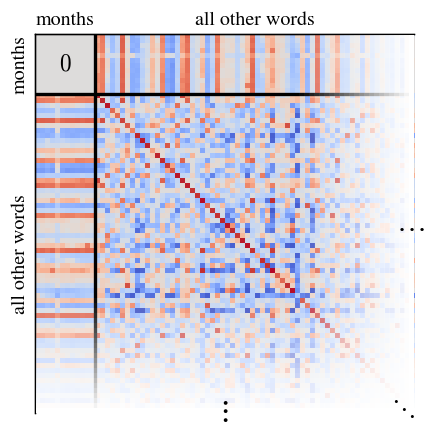

In [12]:
def plot_zero_stats(fig):
    # Use gridspec with proper margins to keep everything inside the subfigure
    gs = fig.add_gridspec(1, 1, left=0.1, right=0.9, top=0.8, bottom=0.01)
    ax = fig.add_subplot(gs[0, 0])

    random_idxs = 200 + np.random.choice(200, size=64, replace=False)
    all_word_idxs = np.concatenate([month_idxs, random_idxs])
    Mstar_randbath = Mstar_zero[np.ix_(all_word_idxs, all_word_idxs)]
    n = Mstar_randbath.shape[0]
    n_months = 12
    ax.matshow(Mstar_randbath, cmap="coolwarm", vmin=-2, vmax=2)

    # quadrant dividers
    ax.axhline(y=n_months - 0.5, xmin=0, color="k", linewidth=2)
    ax.axvline(x=n_months - 0.5, ymax=0.995, color="k", linewidth=2)

    # zero text in month-month submatrix
    ax.text(0.5 * (n_months - 1), 0.5 * (n_months - 1), f"$0$",
            ha="center", va="center", fontsize=14)

    # remove all ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(which="both", bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    # partition labels
    labels = ["months", "all other words"]
    # top
    ax_top = ax.secondary_xaxis("top")
    ax_top.set_xticks([0.5 * (n_months - 1), n_months + 0.5 * ((n - n_months) - 1)])
    ax_top.set_xticklabels(labels)
    ax_top.tick_params(length=0)
    # left
    ax_left = ax.secondary_yaxis("left")
    ax_left.set_yticks([0.5 * (n_months - 1), n_months + 0.5 * ((n - n_months) - 1)])
    ax_left.set_yticklabels(labels, rotation=90, va="center")
    ax_left.tick_params(length=0)

    # Freeze view so later imshow() overlays don't autoscale the axes
    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(n - 0.5, -0.5)

    # Fade on right and bottom edges
    fade_sz = 24
    alpha_overlay = np.outer(np.linspace(0.0, 1, fade_sz), np.ones(n))
    white_overlay_r = np.ones((n, fade_sz))
    # right edge
    ax.imshow(
        white_overlay_r,
        alpha=alpha_overlay.T,
        cmap="gray", vmin=0, vmax=1,
        extent=(n - fade_sz - 0.5, n - 0.5, n - 0.5, -0.1),
        interpolation="nearest", zorder=5,
    )
    # bottom edge
    ax.imshow(
        white_overlay_r.T,
        alpha=alpha_overlay,
        cmap="gray", vmin=0, vmax=1,
        extent=(-0.3, n - 0.5, n - 0.5, n - fade_sz - 0.5),
        interpolation="nearest", zorder=5,
    )

    # remove borders on faded edges
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    # ellipses on bottom, right, bottom-right corner
    center = 0.5 * (n - 1)
    off = 0.95
    d = 1.6
    ax.text(center, n - off, "⋮", ha="center", va="center", fontsize=18, zorder=6)
    ax.text(n - off, center, "…", ha="center", va="center", fontsize=18, zorder=6)
    ax.text(n - off - 2*d, n - off - 2*d, ".", ha="center", va="center", fontsize=16, zorder=6)
    ax.text(n - off - 1*d, n - off - 1*d, ".", ha="center", va="center", fontsize=16, zorder=6)
    ax.text(n - off - 0*d, n - off - 0*d, ".", ha="center", va="center", fontsize=16, zorder=6)


fig = plt.figure(figsize=(4,4))
plot_zero_stats(fig)
plt.show()

/tmp/ipykernel_3673594/600113918.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


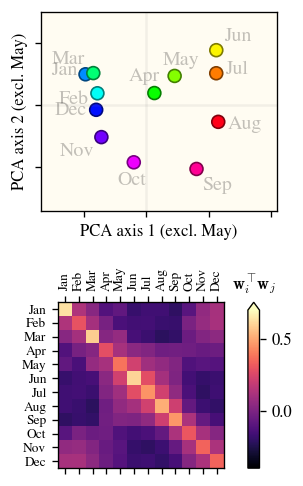

In [13]:
def plot_zero_embeds(fig):
    gs = fig.add_gridspec(
            nrows=2, height_ratios=[3.6,3],
            wspace=0.05, hspace=0.5,
            left=0.02, right=0.97, top=0.87, bottom=0.025
        )
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    scatter_x = 2.2*W_zero_months[:,0]
    scatter_y = 2.2*W_zero_months[:,1]
    center = (0,0)

    ax = axes[0]
    ax.scatter(scatter_x, scatter_y,
            c=month_colors, s=60,
            edgecolors=[darken_color(c, amount=0.5) for c in month_colors])

    eps = 0.15
    for i, month in enumerate(month_abbr):
        x, y = scatter_x[i], scatter_y[i]
        theta = np.arctan2(y - center[1], x - center[0])
        def align(x, neg, pos, eps=0.5):
            return pos if x > eps else neg if x < -eps else 'center'
        ha = align(np.cos(theta), 'right', 'left')
        va = align(np.sin(theta), 'top', 'bottom')
        if month == "May":
            ha = 'center'
        if month == "Apr":
            ha = 'right'
        if month == "Feb":
            va = 'top'
        ax.annotate(
            month, (x + eps*np.cos(theta), y + eps*np.sin(theta)),
            ha=ha, va=va, alpha=0.24
        )

    ax.axhline(0, color='gray', alpha=0.1)
    ax.axvline(0, color='gray', alpha=0.1)

    ax.set_aspect('equal')
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_xlim(-1.7, 2.1)
    ax.set_ylim(-1.7, 1.5)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel("PCA axis 1 (excl. May)", fontsize=10)
    ax.set_ylabel("PCA axis 2 (excl. May)", fontsize=10)

    ax = axes[1]
    vmin, vmax = -0.4, 0.7
    im = ax.matshow(gram_zero, cmap="magma", aspect='equal', vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.set_xticklabels(month_abbr, rotation=90, fontsize=8)
    ax.set_yticklabels(month_abbr, fontsize=8)
    ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top\! \mathbf{w}_j$", pad=8, fontsize=10)
    cax.tick_params(labelsize=10)

fig = plt.figure(figsize=(3, 4.5))
plot_zero_embeds(fig)
plt.tight_layout()
plt.show()

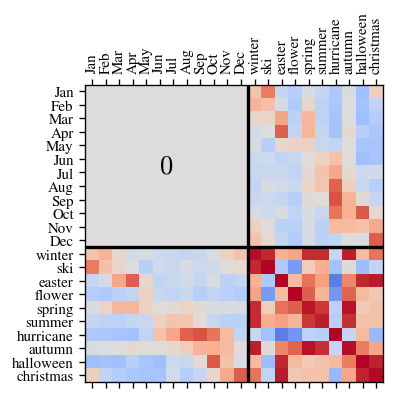

In [14]:
def plot_seasonal_stats(fig):
    # Use gridspec with proper margins to keep everything inside the subfigure
    gs = fig.add_gridspec(1, 1, left=0.2, right=0.95, top=0.67, bottom=0.05)
    ax = fig.add_subplot(gs[0, 0])
    
    n = M_seasonal_zero.shape[0]
    n_months = 12
    ax.matshow(M_seasonal_zero, cmap="coolwarm", vmin=-2, vmax=2)

    # quadrant dividers
    ax.axhline(y=n_months - 0.5, xmin=0, color="k", linewidth=2)
    ax.axvline(x=n_months - 0.5, ymax=0.995, color="k", linewidth=2)

    # zero text in month-month submatrix
    ax.text(0.5 * (n_months - 1), 0.5 * (n_months - 1), f"$0$",
            ha="center", va="center", fontsize=16)

    # remove all ticks
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(month_abbr + seasonal_words, rotation=90, fontsize=9)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(month_abbr + seasonal_words, fontsize=9)

fig = plt.figure(figsize=(4,4))
plot_seasonal_stats(fig)
plt.show()

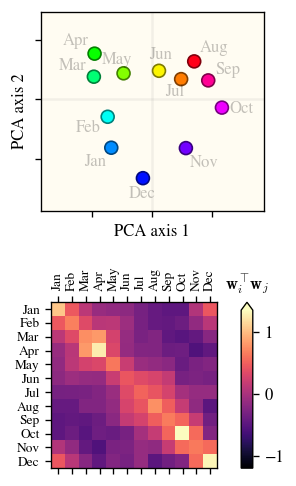

In [15]:
def plot_seasonal_embeds(fig):
    gs = fig.add_gridspec(
            nrows=2, height_ratios=[3.6,3],
            wspace=0.05, hspace=0.5,
            left=0.02, right=0.97, top=0.87, bottom=0.025
        )
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    scatter_x = W_seasonal_zero_months[:,0]
    scatter_y = -W_seasonal_zero_months[:,1]
    center = W_zero_months[:,0:2].mean(axis=0)

    ax = axes[0]
    ax.scatter(scatter_x, scatter_y,
            c=month_colors, s=60,
            edgecolors=[darken_color(c, amount=0.5) for c in month_colors])

    for i, month in enumerate(month_abbr):
        eps = 0.1
        x, y = scatter_x[i], scatter_y[i]
        theta = np.arctan2(y - center[1], x - center[0])
        def align(x, neg, pos, eps=0.3):
            return pos if x > eps else neg if x < -eps else 'center'
        ha = align(np.cos(theta), 'right', 'left')
        va = align(np.sin(theta), 'top', 'bottom')
        if month == "May":
            ha = 'center'
        if month == "Jul":
            ha = 'center'
            va = 'top'
            eps = -eps
        ax.annotate(
            month, (x + eps*np.cos(theta), y + eps*np.sin(theta)),
            ha=ha, va=va, alpha=0.24, fontsize=10
        )

    ax.axhline(0, color='gray', alpha=0.1)
    ax.axvline(0, color='gray', alpha=0.1)

    ax.set_aspect('equal')
    ax.set_xticks([-1.5, -0.75, 0, 0.75, 1.5])
    ax.set_yticks([-1.5, -0.75, 0, 0.75, 1.5])
    ax.set_xlim(-1.4, 1.4)
    ax.set_ylim(-1.4, 1.1)
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel("PCA axis 1", fontsize=10)
    ax.set_ylabel("PCA axis 2", fontsize=10)

    ax = axes[1]
    vmin, vmax = -1.2, 1.35
    im = ax.matshow(gram_seasonal, cmap="magma", aspect='equal', vmax=vmax, vmin=vmin)
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(12))
    ax.set_xticklabels(month_abbr, rotation=90, fontsize=8)
    ax.set_yticklabels(month_abbr, fontsize=8)
    ax.set_aspect('equal')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, extend='max')
    cax.set_title(r"$\mathbf{w}_i^\top \! \mathbf{w}_j$", pad=8, fontsize=10)
    cax.tick_params(labelsize=10)

fig = plt.figure(figsize=(3, 4.5))
plot_seasonal_embeds(fig)
plt.show()

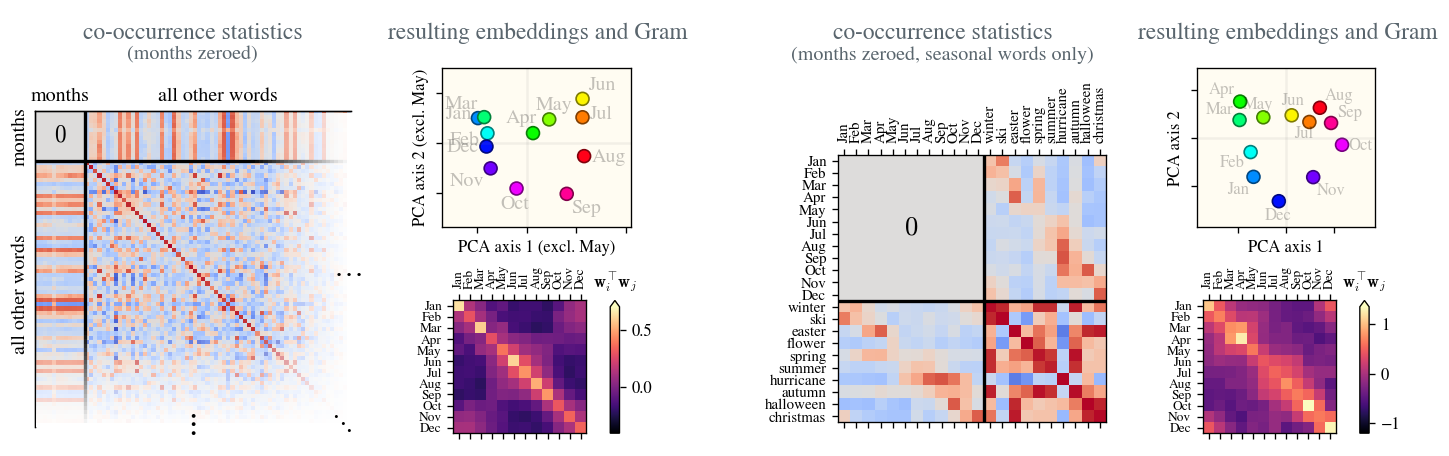

In [16]:
fig = plt.figure(figsize=(12, 3.6))
subfigs = fig.subfigures(1, 5, width_ratios=[4, 3, .6, 4, 3])

# Outline subfigures to see their bounding boxes
# for sf in subfigs:
#     sf.patch.set_edgecolor('red')
#     sf.patch.set_linewidth(2)   
#     sf.patch.set_facecolor('none')

plot_zero_stats(subfigs[0])
subfigs[0].text(0.5,  0.95, s="co-occurrence statistics", fontsize=14,
                ha='center', va='center', color='xkcd:slate gray')
subfigs[0].text(0.5,  0.9, s="(months zeroed)", fontsize=12,
                ha='center', va='center', color='xkcd:slate gray')

plot_zero_embeds(subfigs[1])
subfigs[1].text(0.5,  0.95, s="resulting embeddings and Gram", fontsize=14,
                ha='center', va='center', color='xkcd:slate gray')

plot_seasonal_stats(subfigs[3])
subfigs[3].text(0.5,  0.95, s="co-occurrence statistics", fontsize=14,
                ha='center', va='center', color='xkcd:slate gray')
subfigs[3].text(0.5,  0.9, s="(months zeroed, seasonal words only)", fontsize=12,
                ha='center', va='center', color='xkcd:slate gray')

plot_seasonal_embeds(subfigs[4])
subfigs[4].text(0.5,  0.95, s="resulting embeddings and Gram", fontsize=14,
                ha='center', va='center', color='xkcd:slate gray')

plt.show()
# plt.savefig("plots/fig4.pdf", dpi=300, bbox_inches='tight')